In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter

#### Number of Cores Available

In [2]:
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')
n_available_cores = len(sched_getaffinity(0))
print(f'Number of Available CPU cores: {n_available_cores}')

Number of Logical CPU cores: 64
Number of Available CPU cores: 60


# Initialisation

## Creating Fitness function

In [3]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=False,concat_dim='time', data_vars='minimal',combine='nested',
                       coords='minimal',compat='override').compute().load()
ds_mean = ds.mean(dim='time')['wind_mag'].transpose().compute().load() #finding averages
ds_distances = xr.open_mfdataset("./data/netcdf/UK_coast_distances.nc").compute()
ds_sum = ds.sum(dim='time')


#implement a preloading of summed data for total figures

#grdpnt_power = 30*30*6
grdpnt_power = 13.5*27.5*6
turbine_rating = 8 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


#correlation function definition
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)
def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

In [15]:
def fitness_func(coord_sol, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations."""    
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = globe.is_land(lats, lons)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    #capacity factor (time averaged power factor)
    num_yrs = 24 #years
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    total_output = agg_power.sum()
    avg_output = total_output / (num_yrs * 24*365.25)
    capacity_factor = avg_output.item()/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss

    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))
    distances = np.zeros(combinations)

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()

    for i in range(power_limit.shape[0]):

        ##unavailable##
        store[i] = []
        store_hours[i] = []
        working_ds = agg_power.copy() - power_limit[i]  
        working_ds = working_ds.where(working_ds < 0,0).values
        count = 0 
        num_hours = 0
        #sums the groups
        for j in working_ds:
            if j.item() == 0:
                if count != 0:
                    store[i].append(count)
                    store_hours[i].append(num_hours)
                    count = 0
                    num_hours = 0
            else:
                count += j.item()
                num_hours += 1
        if count != 0:
            store[i].append(count)
            store_hours[i].append(num_hours)
        store[i] = np.abs(np.array(store[i]))/1e6
        store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
        unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit

    ##correlation##           
    count = 0
    #cycle through wind farms
    for i in range(num_farms):
        for j in range(i):
            array1 = ds['power'].sel(latitude = coord_sol[i], longitude = coord_sol[num_farms+i]).compute()
            array2 = ds['power'].sel(latitude = coord_sol[j], longitude = coord_sol[num_farms+j]).compute()
            val = spearman_correlation(array1, array2, 'time')
            ranks[count] = val
            loc1=(coord_sol[i],coord_sol[num_farms+i])
            loc2=(coord_sol[j],coord_sol[num_farms+j])
            distances[count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * (1 - np.average(unavailable_prop))  
               * 1.0**num_onshore_farms * offshore_loss_avg *capacity_factor)
    
    #print('Unavailable prop:',unavailable_prop[:])
    #print('Firm capacity:',firm_capacity[:])
    #print('Avg. correlation:',rank)
    #print('Offshore loss:',offshore_loss_avg)
    #print('Capacity factor:',capacity_factor)
    #print('Fitness:',fitness)
    
    return fitness

## Initialising Genetic Algorithm

In [5]:
fitness_function = fitness_func

num_generations = 20
num_parents_mating = 2

sol_per_pop = 20 #num different groups that can be chosen (# chromosomes)
num_wind_farms = 20 #num wind farms per group 
num_genes = num_wind_farms*2 #num of farms per group (# genes per chromosome)

#create gene_space
gene_space=[]
for i in range(int(num_genes/2)):
    gene_space.append(np.arange(49,63.0,0.25).tolist())
for i in range(int(num_genes/2)):
    gene_space.append(np.arange(-12.5,7.5,0.25).tolist())

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_percent_genes = [30,10]

def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

last_fitness = 0
start_step = time.time()
def on_generation(ga_instance):
    global last_fitness
    global start_step
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    end = time.time()
    print('Time taken:',np.round(end-start_step,decimals=3),'secs \n')
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    start_step = time.time()

In [14]:
ga_instance = pygad.GA(num_generations=num_generations,
                       gene_space = gene_space,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       parallel_processing=["process", 20])
                       

## Running PyGAD



In [10]:
start = time.time()
ga_instance.run()
end = time.time()
print('Time taken:',np.round(end-start,decimals=3))

Generation = 1
Fitness    = 0.13904283243332902
Change     = 0.13904283243332902
Time taken: 344.061 secs 

Generation = 2
Fitness    = 0.14145885984102446
Change     = 0.002416027407695448
Time taken: 261.849 secs 

Generation = 3
Fitness    = 0.14145885984102446
Change     = 0.0
Time taken: 256.135 secs 

Generation = 4
Fitness    = 0.1465044841979086
Change     = 0.005045624356884132
Time taken: 249.484 secs 

Generation = 5
Fitness    = 0.16274429929864184
Change     = 0.016239815100733246
Time taken: 261.275 secs 

Generation = 6
Fitness    = 0.1647774912393991
Change     = 0.0020331919407572674
Time taken: 252.897 secs 

Generation = 7
Fitness    = 0.17061993679567578
Change     = 0.005842445556276665
Time taken: 242.513 secs 

Generation = 8
Fitness    = 0.1729339437417737
Change     = 0.0023140069460979296
Time taken: 240.234 secs 

Generation = 9
Fitness    = 0.17736808891956643
Change     = 0.0044341451777927254
Time taken: 236.575 secs 

Generation = 10
Fitness    = 0.178156

Parameters of the best solution : [ 53.25  49.25  49.    60.5   56.75  58.25  49.25  53.75  50.    59.5
  56.    57.25  62.25  51.    62.25  55.25  62.5   62.25  62.25  58.5
 -12.5  -10.25  -5.5   -7.75   2.25   5.5   -3.25   5.5   -8.75  -2.
   6.   -12.25 -12.   -10.     3.   -11.5    3.5  -11.75   2.   -11.5 ]
Fitness value of the best solution = 0.1867030244020802


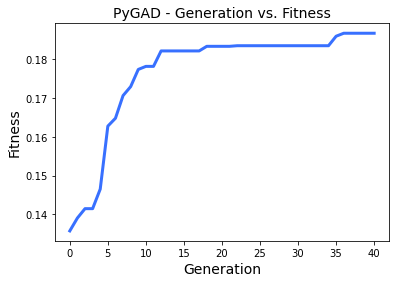

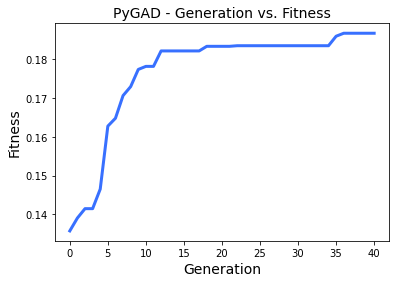

In [12]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
ga_instance.plot_fitness()

### Plotting Locations

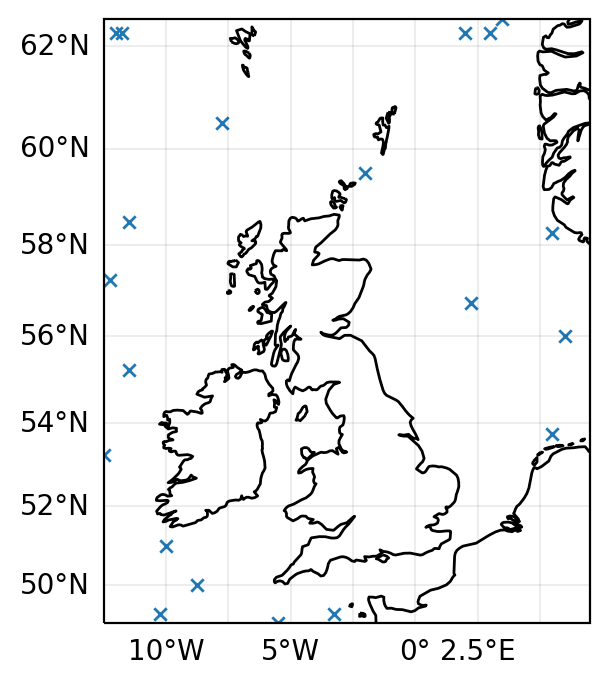

In [13]:
num_farms = int(solution.shape[0]/2)
edge =-0.05

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])
plt.scatter(x=solution[num_farms:], y=solution[:num_farms],marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=1) 


divider = make_axes_locatable(ax)

## Edited Fitness function

Changed offshore cable loss from 3.5% per 1000km to 35% per 1000km.

In [16]:
def fitness_func_cable_loss(coord_sol, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations."""    
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = (ds_mean.sel(latitude = lats, longitude = lons) < 7.6)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    #capacity factor (time averaged power factor)
    num_yrs = 24 #years
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    total_output = agg_power.sum()
    avg_output = total_output / (num_yrs * 24*365.25)
    capacity_factor = avg_output.item()/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.35 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss

    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))
    distances = np.zeros(combinations)

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()

    for i in range(power_limit.shape[0]):

        ##unavailable##
        store[i] = []
        store_hours[i] = []
        working_ds = agg_power.copy() - power_limit[i]  
        working_ds = working_ds.where(working_ds < 0,0).values
        count = 0 
        num_hours = 0
        #sums the groups
        for j in working_ds:
            if j.item() == 0:
                if count != 0:
                    store[i].append(count)
                    store_hours[i].append(num_hours)
                    count = 0
                    num_hours = 0
            else:
                count += j.item()
                num_hours += 1
        if count != 0:
            store[i].append(count)
            store_hours[i].append(num_hours)
        store[i] = np.abs(np.array(store[i]))/1e6
        store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
        unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit

    ##correlation##           
    count = 0
    #cycle through wind farms
    for i in range(num_farms):
        for j in range(i):
            array1 = ds['power'].sel(latitude = coord_sol[i], longitude = coord_sol[num_farms+i]).compute()
            array2 = ds['power'].sel(latitude = coord_sol[j], longitude = coord_sol[num_farms+j]).compute()
            val = spearman_correlation(array1, array2, 'time')
            ranks[count] = val
            loc1=(coord_sol[i],coord_sol[num_farms+i])
            loc2=(coord_sol[j],coord_sol[num_farms+j])
            distances[count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * (1 - np.average(unavailable_prop))  
               * 1.0**num_onshore_farms * offshore_loss_avg *capacity_factor)
    
    #print('Unavailable prop:',unavailable_prop[:])
    #print('Firm capacity:',firm_capacity[:])
    #print('Avg. correlation:',rank)
    #print('Offshore loss:',offshore_loss_avg)
    #print('Capacity factor:',capacity_factor)
    #print('Fitness:',fitness)
    
    return fitness

def fitness_func_manual(coord_sol):
    """Manual fitness function to be used outside of genetic algorithm."""
    solution_idx = 0
    return fitness_func(coord_sol, solution_idx)

In [30]:
fitness_function = fitness_func_cable_loss

ga_instance = pygad.GA(num_generations= num_generations,
                       gene_space = gene_space,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop= sol_per_pop,
                       num_genes= num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       parallel_processing=["process", 20])

In [31]:
start = time.time()
ga_instance.run()
end = time.time()
print('Time taken:',np.round(end-start,decimals=3))

Generation = 1
Fitness    = 0.13783584256553388
Change     = 0.13783584256553388
Time taken: 245.369 secs 

Generation = 2
Fitness    = 0.15090823985519758
Change     = 0.013072397289663695
Time taken: 213.932 secs 

Generation = 3
Fitness    = 0.15702282637648274
Change     = 0.006114586521285159
Time taken: 278.175 secs 

Generation = 4
Fitness    = 0.15933424288309989
Change     = 0.0023114165066171477
Time taken: 307.258 secs 

Generation = 5
Fitness    = 0.15933424288309989
Change     = 0.0
Time taken: 317.122 secs 

Generation = 6
Fitness    = 0.15933424288309989
Change     = 0.0
Time taken: 282.126 secs 

Generation = 7
Fitness    = 0.1625260178376173
Change     = 0.003191774954517418
Time taken: 291.426 secs 

Generation = 8
Fitness    = 0.1625260178376173
Change     = 0.0
Time taken: 258.772 secs 

Generation = 9
Fitness    = 0.1625260178376173
Change     = 0.0
Time taken: 312.634 secs 

Generation = 10
Fitness    = 0.1625260178376173
Change     = 0.0
Time taken: 251.04 secs 


Parameters of the best solution : [ 49.    57.5   49.75  59.5   60.75  59.75  50.75  54.75  57.5   61.75
  52.5   54.75  61.5   50.75  49.75  60.25  53.5   58.75  62.5   57.75
 -12.25 -11.75  -8.75  -1.75 -10.75 -11.25  -8.25   2.     3.75 -12.5
   3.     5.     3.   -12.    -0.75 -11.     2.5  -11.75 -10.25  -9.25]
Fitness value of the best solution = 0.16090065841369466


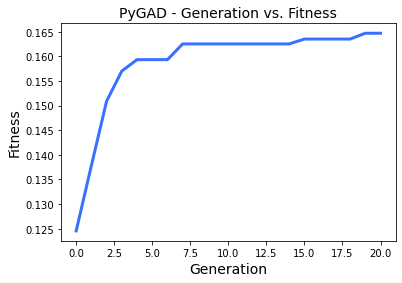

In [32]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
ga_instance.plot_fitness()

np.savetxt(f'./data/farm_locations/locs_cable_loss',solution)

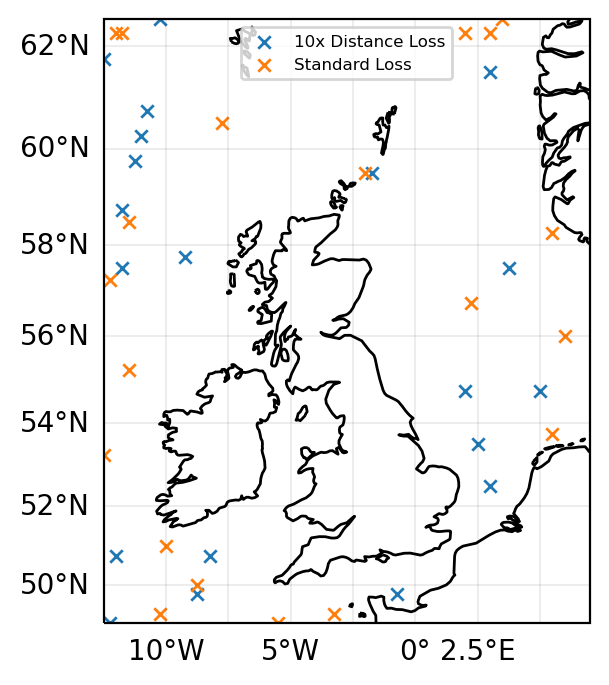

In [55]:
solution = np.loadtxt(f'./data/farm_locations/locs_cable_loss')
num_farms = int(solution.shape[0]/2)
edge =-0.05

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])


plt.scatter(x=solution[num_farms:], y=solution[:num_farms],marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=1, label=('10x Distance Loss')) 

standard = np.loadtxt(f'./data/farm_locations/locs_standard')
plt.scatter(x=standard[num_farms:], y=standard[:num_farms],marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=1, label=('Standard Loss')) 
plt.legend(loc=9, prop={'size': 6})
divider = make_axes_locatable(ax)

# Plotting Multiple Runs

In [21]:
#loading locations
farm_locations = dict()
for i in range(10):
    farm_locations[i] = np.loadtxt(f'./data/farm_locations/locs_cable_loss{i}')

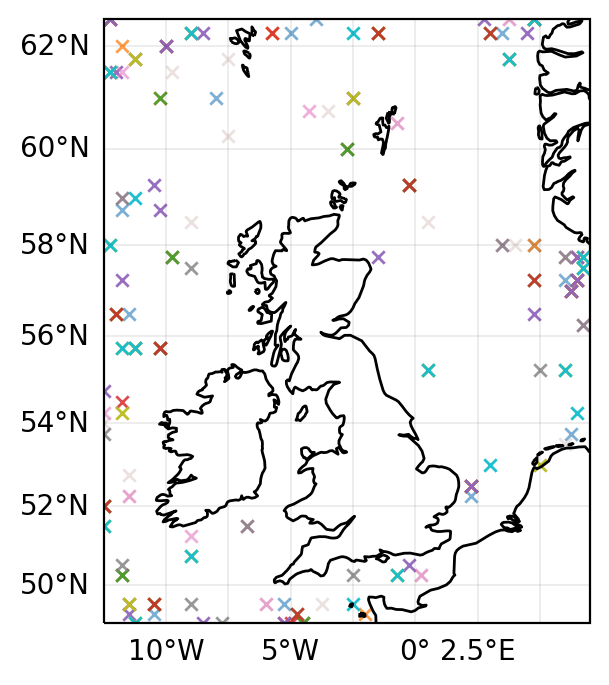

In [36]:
num_farms = int(farm_locations[i].shape[0]/2)
edge =-0.05

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])

for i in range(10):
    plt.scatter(x=farm_locations[i][num_farms:], y=farm_locations[i][:num_farms],marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=1,alpha=(fitness_arr[i]*50 -8.7))#fitness_arr) 


divider = make_axes_locatable(ax)

# Single Gene Locations

Changing the fitness function to use single genes that pack the longitude and latitude together to see if this can increase the fitness.

In [46]:
def fitness_func_idx(coord_idx, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations."""
    
    #convert indexes to locations
    lat_idx = coord_idx%55
    lat_idx = lat_idx.astype(int)
    lon_idx = (coord_idx-lat_idx)/55
    lon_idx = lon_idx.astype(int)
    lats = np.arange(49,63.0,0.25)[lat_idx]
    lons = np.arange(-12.5,7.5,0.25)[lon_idx]
    coord_sol = np.hstack((lats,lons))
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = (ds_mean.sel(latitude = lats, longitude = lons) < 7.6)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    #capacity factor (time averaged power factor)
    num_yrs = 24 #years
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    total_output = agg_power.sum()
    avg_output = total_output / (num_yrs * 24*365.25)
    capacity_factor = avg_output.item()/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss

    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))
    distances = np.zeros(combinations)

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()

    for i in range(power_limit.shape[0]):

        ##unavailable##
        store[i] = []
        store_hours[i] = []
        working_ds = agg_power.copy() - power_limit[i]  
        working_ds = working_ds.where(working_ds < 0,0).values
        count = 0 
        num_hours = 0
        #sums the groups
        for j in working_ds:
            if j.item() == 0:
                if count != 0:
                    store[i].append(count)
                    store_hours[i].append(num_hours)
                    count = 0
                    num_hours = 0
            else:
                count += j.item()
                num_hours += 1
        if count != 0:
            store[i].append(count)
            store_hours[i].append(num_hours)
        store[i] = np.abs(np.array(store[i]))/1e6
        store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
        unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit

    ##correlation##           
    count = 0
    #cycle through wind farms
    for i in range(num_farms):
        for j in range(i):
            array1 = ds['power'].sel(latitude = coord_sol[i], longitude = coord_sol[num_farms+i]).compute()
            array2 = ds['power'].sel(latitude = coord_sol[j], longitude = coord_sol[num_farms+j]).compute()
            val = spearman_correlation(array1, array2, 'time')
            ranks[count] = val
            loc1=(coord_sol[i],coord_sol[num_farms+i])
            loc2=(coord_sol[j],coord_sol[num_farms+j])
            distances[count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * (1 - np.average(unavailable_prop))  
               * 1.0**num_onshore_farms * offshore_loss_avg *capacity_factor)
    
    #print('Unavailable prop:',unavailable_prop[:])
    #print('Firm capacity:',firm_capacity[:])
    #print('Avg. correlation:',rank)
    #print('Offshore loss:',offshore_loss_avg)
    #print('Capacity factor:',capacity_factor)
    #print('Fitness:',fitness)
    
    return fitness

In [61]:
fitness_function = fitness_func_idx

num_generations = 20
num_parents_mating = 2

sol_per_pop = 20 #num different groups that can be chosen (# chromosomes)
num_genes = 20 #num of farms per group (# genes per chromosome)

#create gene_space
gene_space=np.arange(0,4345)

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_percent_genes = [30,10]

def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

last_fitness = 0
start_step = time.time()
def on_generation(ga_instance):
    global last_fitness
    global start_step
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    end = time.time()
    print('Time taken:',np.round(end-start_step,decimals=3),'secs \n')
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    start_step = time.time()

In [62]:
ga_instance = pygad.GA(num_generations=num_generations,
                       gene_space = gene_space,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       parallel_processing=["process",sol_per_pop])
                       

In [63]:
start = time.time()
ga_instance.run()
end = time.time()
print('Time taken:',np.round(end-start,decimals=3))

Generation = 1
Fitness    = 0.1409629423010112
Change     = 0.1409629423010112
Time taken: 187.043 secs 

Generation = 2
Fitness    = 0.14922178332216218
Change     = 0.008258841021150987
Time taken: 171.59 secs 

Generation = 3
Fitness    = 0.1574603690989445
Change     = 0.008238585776782326
Time taken: 168.472 secs 

Generation = 4
Fitness    = 0.1604534252494392
Change     = 0.002993056150494694
Time taken: 167.816 secs 

Generation = 5
Fitness    = 0.16569223573770595
Change     = 0.005238810488266743
Time taken: 169.075 secs 

Generation = 6
Fitness    = 0.17385382894885068
Change     = 0.008161593211144735
Time taken: 166.531 secs 

Generation = 7
Fitness    = 0.17985235333838093
Change     = 0.0059985243895302465
Time taken: 167.113 secs 

Generation = 8
Fitness    = 0.18004116979566226
Change     = 0.00018881645728133223
Time taken: 165.526 secs 

Generation = 9
Fitness    = 0.18119087885031845
Change     = 0.001149709054656195
Time taken: 166.167 secs 

Generation = 10
Fitnes

Parameters of the best solution : [ 440. 1256. 3622. 3832.  238.  582. 2368. 4256. 1915. 4051.  226.  328.
  769. 3878. 1690. 3738. 3260.  159.  688.  555.]
Fitness value of the best solution = 0.18405376599681908


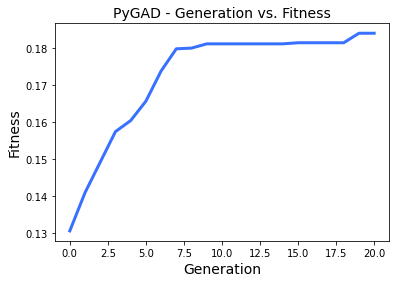

Figure(432x288)


In [64]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print(ga_instance.plot_fitness())

# Plotting Multiple Runs with Single Gene and without Spec

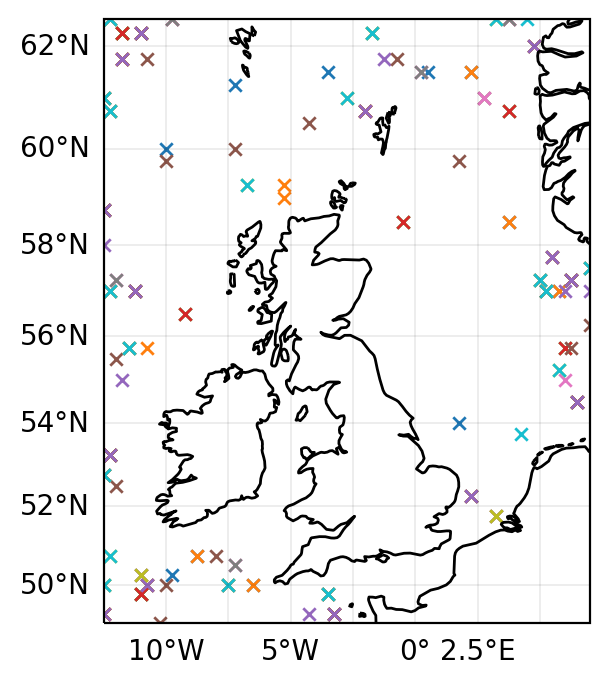

In [88]:
#loading locations
farm_locations = dict()
coord_sol = dict()
for i in range(10):
    farm_locations[i] = np.loadtxt(f'./data/farm_locations/locs_idx{i}')
    lat_idx = farm_locations[i]%55
    lat_idx = lat_idx.astype(int)
    lon_idx = (farm_locations[i]-lat_idx)/55
    lon_idx = lon_idx.astype(int)
    lats = np.arange(49,63.0,0.25)[lat_idx]
    lons = np.arange(-12.5,7.5,0.25)[lon_idx]
    coord_sol[i] = np.hstack((lats,lons))

num_farms = int(coord_sol[i].shape[0]/2)
edge =-0.05

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])

for i in range(10):
    plt.scatter(x=coord_sol[i][num_farms:], y=coord_sol[i][:num_farms],marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=1)#fitness_arr) 


divider = make_axes_locatable(ax)